version info:  

**analysis5.ipynb** - the primary addition is calculating statistical significance between before and after for the QSUM groups (See section: "First vs. Second").

**analysis4.ipynb** - the primary addition is calculating question sums using the 3 E's as categories.

final.csv contains most all of the data for analysis. Things that it does not contain are:
* participant demographics
  * age, gender, race, (note it does contain "background")

Characteristics:  
* Each row retpresents a reviewer rating, done by either a third party ('TP') or a standardized patient ('SP') (REVIEWER_TYPE = {'SP','TP'}.

* Each participant does two sessions ('FIRST_SECOND' = {'First','Second'}).

* Participants were randomly assigned to one of two Arms: SOPHIE or Control('ARM' = {'S','C'})

*


## SUMMARY:

* dQSUM between the ARMs is significantly different considering TP only
* dQSUM between the ARMs is significantly different considering SP and TP combined.
* The inter-rater reliability using the Intra-Class Correlation Coefficient (ICC) finds that for the purpose of using averaged relative ratings, the ratings have "very good consistency"


## Concerns:
* TP produced dQSUM are substantially different than SP dQSUM (with SP dQSUM much larger). Do we have a reasonable explanation of this? Is part of it bias since the SP will know which is the first vs. second interaction.
* The Cohen's kappa measure seems not appropriate since the sum of the ratings is numerical as opposed to categorical - this seems contrary to the group's understanding/expectation.

## Questions
* It is crucial point to confirm that the 3rd party reviewers did not know which video was before and after. This will go a long way in terms of "trusting" value of the ratings.
* Does SOPHIE generate a score? If not, can we generate a SCORE based on a multimodal model.

## Other

* Even though there was a lot of data "cleaning", none of the cleaning steps were questionable.




In [1]:
# SPECIFY INPUT FILES
DATAFILE = 'data/final.csv'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 600
pd.options.display.max_columns = 600


In [3]:
# LOAD THE DATAFILE; SHOW COUNTS AND SAMPLE DATA
df = pd.read_csv(DATAFILE)
print('Q: Do the experiment counts seem reasonable?\n')
print('DATAFILE COUNTS')
print('shape: \t\t', df.shape)
assert df.shape == (506, 28), "ERROR: Change in input file size"


print('# P_ID: \t\t', df['P_ID'].nunique())
print('# P_ID: ARM S\t', df[df['ARM'] == 'S']['P_ID'].nunique())
print('# P_ID: ARM C\t', df[df['ARM'] == 'C']['P_ID'].nunique())
print('# VIDEO_NUM: \t', df['VIDEO_NUM'].nunique())
print('# reviews: \t\t', df.shape[0])
print('# reviews: ARM S', (df['ARM'] == 'S').sum())
print('# reviews: ARM C', (df['ARM'] == 'C').sum())
#print('# CASE_TITLE: \t', df['CASE_TITLE'].nunique())
#print('# P_BACKGROUND:', df['P_BACKGROUND'].nunique())
print('# SP_NAME: \t', df['SP_NAME'].nunique())
print('# TP: \t', df[df['REVIEWER_TYPE']=='TP']['REVIEWER_NAME'].nunique())
print('# REVIEWER_NAME:', df['REVIEWER_NAME'].nunique())

#print('CASE_TITLEs: \t', df['CASE_TITLE'].unique())
print('# \t', df['CASE_TITLE'].value_counts())
#print('P_BACKGROUNDs:\t', df['P_BACKGROUND'].unique())
print('# \t', df[['P_ID','P_BACKGROUND']].drop_duplicates()['P_BACKGROUND'].
      value_counts())
print('REVIEWER_NAMEs: \t', df['REVIEWER_NAME'].unique())

print('------------------------------------')


display(df.head())


Q: Do the experiment counts seem reasonable?

DATAFILE COUNTS
shape: 		 (506, 28)
# P_ID: 		 51
# P_ID: ARM S	 26
# P_ID: ARM C	 25
# VIDEO_NUM: 	 102
# reviews: 		 506
# reviews: ARM S 257
# reviews: ARM C 249
# SP_NAME: 	 13
# TP: 	 4
# REVIEWER_NAME: 17
# 	 CASE_TITLE
Lois Bell      183
Pat Smith      168
Jill Cooper    155
Name: count, dtype: int64
# 	 P_BACKGROUND
Student    25
Nurse      19
PhD         4
PA          2
Doctor      1
Name: count, dtype: int64
REVIEWER_NAMEs: 	 ['SP11' 'SP0' 'SP4' 'SP5' 'SP7' 'SP10' 'SP3' 'SP6' 'SP12' 'SP9' 'SP2'
 'SP1' 'SP8' 'TP2' 'TP1' 'TP0' 'TP3']
------------------------------------


,VIDEO_NUM,P_ID,ARM,FIRST_SECOND,CASE_TITLE,P_BACKGROUND,SP_NAME,REVIEWER_NAME,REVIEWER_TYPE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,video1829885929,1,S,First,Pat Smith,Student,SP11,SP11,SP,1,1,1,1,1,2,9,4,5,5,1,3,9,4,4,1,5,8,4
1,video8829885929,1,S,Second,Lois Bell,Student,SP11,SP11,SP,2,5,1,1,5,5,8,5,5,5,1,5,10,3,4,4,5,7,5
2,video1757986894,0,C,First,Lois Bell,PA,SP0,SP0,SP,5,2,1,3,3,5,8,4,2,5,1,5,9,5,5,4,5,10,10
3,video2757986894,0,C,Second,Pat Smith,PA,SP0,SP0,SP,5,2,5,3,5,5,10,5,1,5,1,5,10,5,5,4,5,10,10
4,video1631554860,2,S,First,Jill Cooper,Student,SP4,SP4,SP,5,1,1,1,5,5,4,4,5,5,1,2,8,2,3,5,2,2,2


In [4]:
# PRINT INDEX NUMBERS FOR COLUMN NAMES
for i, col in enumerate(df.columns):
  print(i, col)

0 VIDEO_NUM
1 P_ID
2 ARM
3 FIRST_SECOND
4 CASE_TITLE
5 P_BACKGROUND
6 SP_NAME
7 REVIEWER_NAME
8 REVIEWER_TYPE
9 Q1
10 Q2
11 Q3
12 Q4
13 Q5
14 Q6
15 Q7
16 Q8
17 Q9
18 Q10
19 Q11
20 Q12
21 Q13
22 Q14
23 Q15
24 Q16
25 Q17
26 Q18
27 Q19


In [5]:
# CREATE CATEGORY VARIABLES
QUESTIONS_ALL = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q11','Q12',
                 'Q13','Q14','Q15','Q16','Q17','Q18','Q19']
QUESTIONS_EMPOWER = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7']
QUESTIONS_EXPLICIT = ['Q8','Q9','Q10','Q11','Q12','Q13']
QUESTIONS_EMPATHY = ['Q14','Q15','Q16','Q17','Q18']
question_groups = [QUESTIONS_EMPOWER, QUESTIONS_EXPLICIT, QUESTIONS_EMPATHY,
                   QUESTIONS_ALL]

QUEST_MAX_POINTS_EMPOWER = 40
QUEST_MAX_POINTS_EXPLICIT = 35
QUEST_MAX_POINTS_EMPATHY = 30
QUEST_MAX_POINTS_ALL = 115

sum_groups = ['QSUM_EMPOWER', 'QSUM_EXPLICIT', 'QSUM_EMPATHY', 'QSUM_ALL']
dsum_groups = ['dQSUM_EMPOWER', 'dQSUM_EXPLICIT', 'dQSUM_EMPATHY', 'dQSUM_ALL']
groups = ['REVIEWER_TYPE','P_BACKGROUND','ARM','CASE_TITLE','REVIEWER_NAME']

### QSUM

In [6]:
# Flip negative question, Q11, i.e. {1,2,3,4,5} --> {5,4,3,2,1} Q11 = 6 - Q11
df['Q11'] = 6 - df['Q11']
display(df.head())

,VIDEO_NUM,P_ID,ARM,FIRST_SECOND,CASE_TITLE,P_BACKGROUND,SP_NAME,REVIEWER_NAME,REVIEWER_TYPE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,video1829885929,1,S,First,Pat Smith,Student,SP11,SP11,SP,1,1,1,1,1,2,9,4,5,5,5,3,9,4,4,1,5,8,4
1,video8829885929,1,S,Second,Lois Bell,Student,SP11,SP11,SP,2,5,1,1,5,5,8,5,5,5,5,5,10,3,4,4,5,7,5
2,video1757986894,0,C,First,Lois Bell,PA,SP0,SP0,SP,5,2,1,3,3,5,8,4,2,5,5,5,9,5,5,4,5,10,10
3,video2757986894,0,C,Second,Pat Smith,PA,SP0,SP0,SP,5,2,5,3,5,5,10,5,1,5,5,5,10,5,5,4,5,10,10
4,video1631554860,2,S,First,Jill Cooper,Student,SP4,SP4,SP,5,1,1,1,5,5,4,4,5,5,5,2,8,2,3,5,2,2,2


In [7]:
# CREATE QSUM COLUMNS
# NOTE: It may make sense to rescale the questions that are on a scale of 10
df['QSUM_EMPOWER'] = df[QUESTIONS_EMPOWER].sum(axis=1)/QUEST_MAX_POINTS_EMPOWER
df['QSUM_EXPLICIT'] = df[QUESTIONS_EXPLICIT].sum(axis=1)/QUEST_MAX_POINTS_EXPLICIT
df['QSUM_EMPATHY'] = df[QUESTIONS_EMPATHY].sum(axis=1)/QUEST_MAX_POINTS_EMPATHY
df['QSUM_ALL'] = df[QUESTIONS_ALL].sum(axis=1)/QUEST_MAX_POINTS_ALL
#df.head()
display(df.head())

,VIDEO_NUM,P_ID,ARM,FIRST_SECOND,CASE_TITLE,P_BACKGROUND,SP_NAME,REVIEWER_NAME,REVIEWER_TYPE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,QSUM_EMPOWER,QSUM_EXPLICIT,QSUM_EMPATHY,QSUM_ALL
0,video1829885929,1,S,First,Pat Smith,Student,SP11,SP11,SP,1,1,1,1,1,2,9,4,5,5,5,3,9,4,4,1,5,8,4,0.400,0.885714,0.733333,0.634783
1,video8829885929,1,S,Second,Lois Bell,Student,SP11,SP11,SP,2,5,1,1,5,5,8,5,5,5,5,5,10,3,4,4,5,7,5,0.675,1.000000,0.766667,0.782609
2,video1757986894,0,C,First,Lois Bell,PA,SP0,SP0,SP,5,2,1,3,3,5,8,4,2,5,5,5,9,5,5,4,5,10,10,0.675,0.857143,0.966667,0.834783
3,video2757986894,0,C,Second,Pat Smith,PA,SP0,SP0,SP,5,2,5,3,5,5,10,5,1,5,5,5,10,5,5,4,5,10,10,0.875,0.885714,0.966667,0.913043
4,video1631554860,2,S,First,Jill Cooper,Student,SP4,SP4,SP,5,1,1,1,5,5,4,4,5,5,5,2,8,2,3,5,2,2,2,0.550,0.828571,0.466667,0.582609


## Exporting data

In [8]:
# prompt: export df as csv

# Export the DataFrame to a CSV file
df.to_csv('merged_by_ty.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('merged_by_ty.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,QSUM_EMPOWER
count,506.000000
mean,0.509239
std,0.187862
min,0.175000
25%,0.350000
50%,0.500000
75%,0.650000
max,1.000000


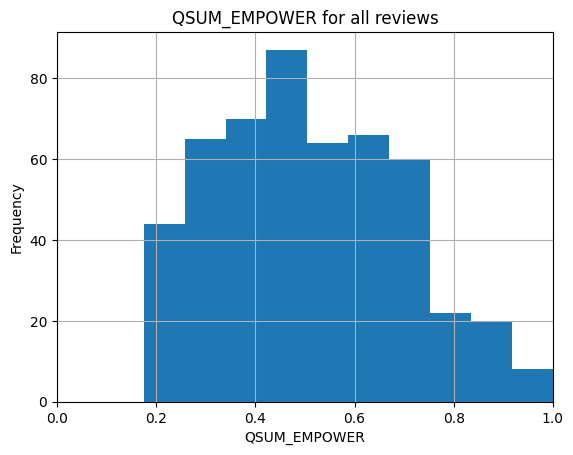

,QSUM_EXPLICIT
count,506.000000
mean,0.727386
std,0.146724
min,0.257143
25%,0.628571
50%,0.742857
75%,0.828571
max,1.000000


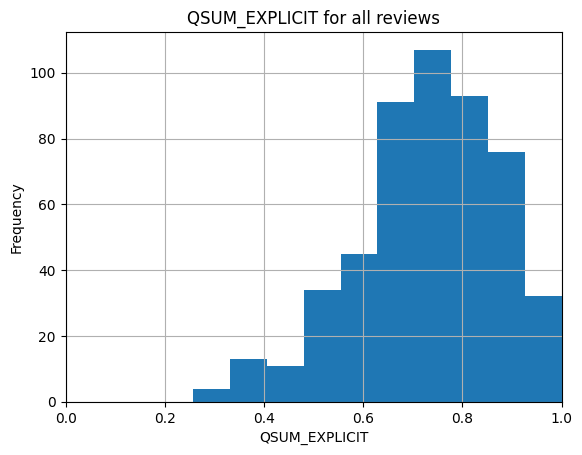

,QSUM_EMPATHY
count,506.000000
mean,0.598880
std,0.208607
min,0.166667
25%,0.433333
50%,0.600000
75%,0.733333
max,1.000000


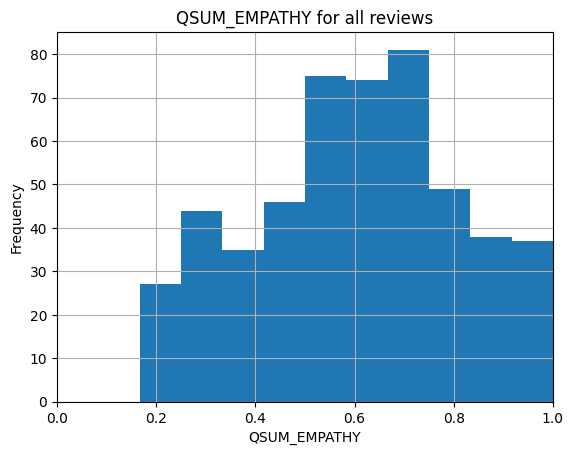

,QSUM_ALL
count,506.000000
mean,0.604176
std,0.161010
min,0.191304
25%,0.486957
50%,0.600000
75%,0.713043
max,1.000000


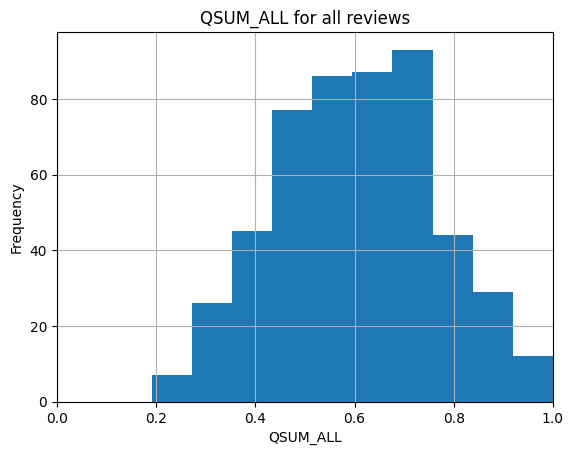

In [9]:
# DISPLAY BASIC QSUM STATS AND HISTOGRAM FOR EACH SUM GROUP
for sum_group in sum_groups:
  display(df[sum_group].describe())
  df[sum_group].hist()
  plt.xlabel(sum_group)
  plt.ylabel('Frequency')
  plt.title(sum_group + ' for all reviews')
  plt.xlim(0,1)
  plt.show()

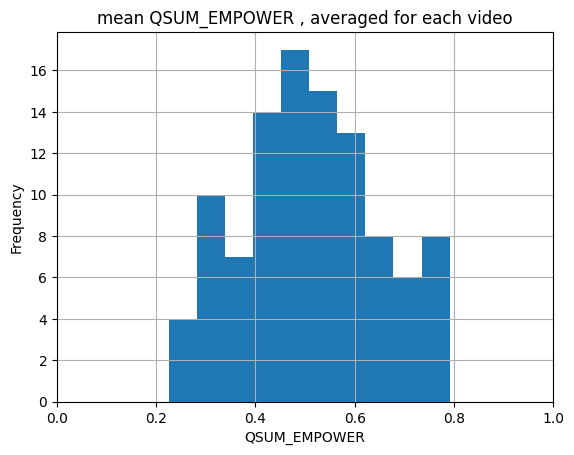

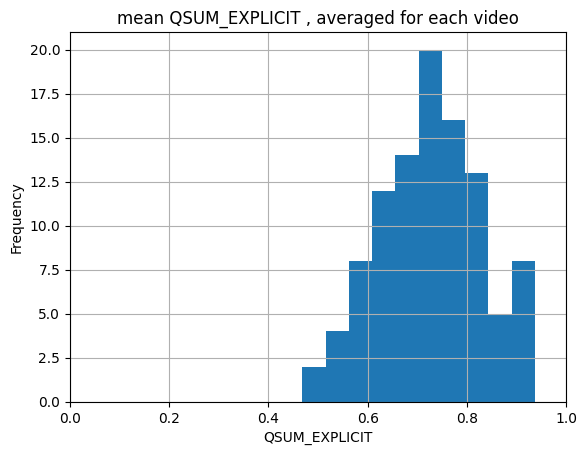

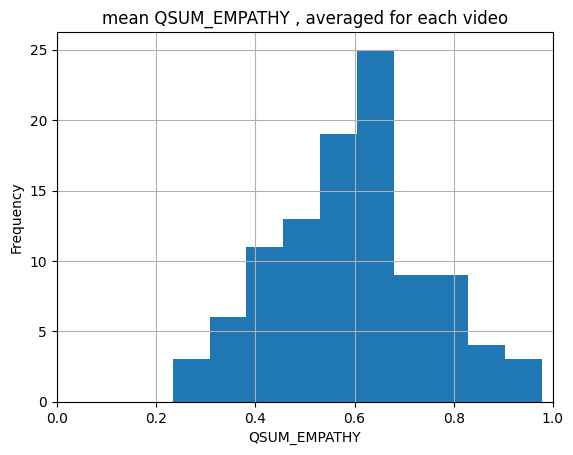

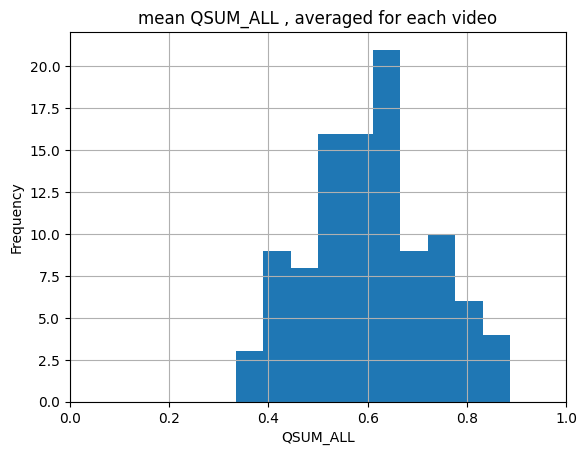

In [10]:
g_VIDEO_NUM = df.groupby('VIDEO_NUM')
#display(g_VIDEO_NUM['QSUM'].mean())
for sum_group in sum_groups:
  g_VIDEO_NUM[sum_group].mean().hist()
  plt.xlabel(sum_group)
  plt.ylabel('Frequency')
  plt.title('mean ' + sum_group + ' , averaged for each video')
  plt.xlim(0,1)
  plt.show()

In [11]:
# COMPARE QSUM MEANS AND SAMPLE COUNTS BY DIFFERENT GROUPINGS
print('FIRST SESSION ONLY - counts and means by group')
for group in groups:
  g = df[df['FIRST_SECOND'] == 'First'].groupby(group)
  for sum_group in sum_groups:
    print('-----------------------')
    print('SUMGROUP: ' + sum_group)
    display(g[sum_group].describe())

FIRST SESSION ONLY - counts and means by group
-----------------------
SUMGROUP: QSUM_EMPOWER


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.455882,0.195550,0.175,0.3,0.40,0.5625,0.9
TP,203.0,0.451108,0.171847,0.175,0.3,0.45,0.5750,0.9


-----------------------
SUMGROUP: QSUM_EXPLICIT


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.675070,0.163828,0.371429,0.571429,0.657143,0.814286,1.000000
TP,203.0,0.686418,0.146307,0.257143,0.600000,0.685714,0.800000,0.971429


-----------------------
SUMGROUP: QSUM_EMPATHY


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.581046,0.227083,0.200000,0.400000,0.566667,0.733333,1.0
TP,203.0,0.538095,0.209626,0.166667,0.366667,0.533333,0.700000,1.0


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.560443,0.168833,0.304348,0.430435,0.530435,0.686957,0.947826
TP,203.0,0.551210,0.154981,0.191304,0.447826,0.547826,0.673913,0.930435


-----------------------
SUMGROUP: QSUM_EMPOWER


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.310000,0.136473,0.225,0.22500,0.2750,0.27500,0.550
Nurse,95.0,0.422895,0.158394,0.175,0.30000,0.3750,0.52500,0.875
PA,10.0,0.602500,0.169333,0.350,0.48125,0.5500,0.76875,0.850
PhD,20.0,0.515000,0.217098,0.175,0.26875,0.5875,0.68125,0.850
Student,124.0,0.457863,0.175778,0.175,0.30000,0.4500,0.57500,0.900


-----------------------
SUMGROUP: QSUM_EXPLICIT


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.594286,0.205436,0.428571,0.457143,0.571429,0.571429,0.942857
Nurse,95.0,0.646316,0.149230,0.257143,0.571429,0.657143,0.742857,1.000000
PA,10.0,0.748571,0.178581,0.342857,0.685714,0.757143,0.878571,0.942857
PhD,20.0,0.754286,0.142827,0.485714,0.642857,0.814286,0.885714,0.914286
Student,124.0,0.700230,0.139281,0.314286,0.621429,0.714286,0.807143,1.000000


-----------------------
SUMGROUP: QSUM_EMPATHY


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.346667,0.123828,0.166667,0.266667,0.433333,0.433333,0.433333
Nurse,95.0,0.518947,0.201686,0.166667,0.366667,0.500000,0.683333,0.966667
PA,10.0,0.780000,0.194492,0.466667,0.633333,0.816667,0.933333,1.000000
PhD,20.0,0.633333,0.234957,0.233333,0.450000,0.683333,0.808333,1.000000
Student,124.0,0.543280,0.207318,0.166667,0.366667,0.533333,0.700000,1.000000


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.408696,0.120804,0.295652,0.295652,0.382609,0.521739,0.547826
Nurse,95.0,0.522471,0.146907,0.191304,0.421739,0.504348,0.613043,0.869565
PA,10.0,0.705217,0.164246,0.486957,0.573913,0.691304,0.847826,0.930435
PhD,20.0,0.624348,0.179356,0.286957,0.471739,0.686957,0.769565,0.834783
Student,124.0,0.558555,0.151135,0.252174,0.452174,0.556522,0.671739,0.947826


-----------------------
SUMGROUP: QSUM_EMPOWER


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.491331,0.182715,0.175,0.35,0.475,0.625,0.900
S,130.0,0.414615,0.162311,0.175,0.30,0.350,0.550,0.775


-----------------------
SUMGROUP: QSUM_EXPLICIT


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.707604,0.144042,0.314286,0.600000,0.714286,0.828571,1.000000
S,130.0,0.661758,0.152137,0.257143,0.571429,0.685714,0.771429,0.942857


-----------------------
SUMGROUP: QSUM_EMPATHY


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.583602,0.206511,0.200000,0.433333,0.566667,0.733333,1.0
S,130.0,0.511538,0.214854,0.166667,0.333333,0.483333,0.700000,1.0


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.588008,0.160081,0.286957,0.469565,0.565217,0.721739,0.947826
S,130.0,0.519732,0.148187,0.191304,0.393478,0.517391,0.626087,0.834783


-----------------------
SUMGROUP: QSUM_EMPOWER


,count,mean,std,min,25%,50%,75%,max
CASE_TITLE,,,,,,,,
Jill Cooper,95.0,0.458947,0.178234,0.175,0.300,0.475,0.600,0.85
Lois Bell,94.0,0.462500,0.171480,0.175,0.325,0.425,0.550,0.90
Pat Smith,65.0,0.426923,0.181213,0.175,0.275,0.375,0.575,0.90


-----------------------
SUMGROUP: QSUM_EXPLICIT


,count,mean,std,min,25%,50%,75%,max
CASE_TITLE,,,,,,,,
Jill Cooper,95.0,0.704060,0.152496,0.257143,0.600000,0.714286,0.828571,1.000000
Lois Bell,94.0,0.650760,0.156613,0.285714,0.571429,0.657143,0.742857,1.000000
Pat Smith,65.0,0.703297,0.127345,0.314286,0.628571,0.714286,0.800000,0.942857


-----------------------
SUMGROUP: QSUM_EMPATHY


,count,mean,std,min,25%,50%,75%,max
CASE_TITLE,,,,,,,,
Jill Cooper,95.0,0.525614,0.221079,0.166667,0.333333,0.500000,0.700000,1.0
Lois Bell,94.0,0.553546,0.207748,0.166667,0.408333,0.533333,0.691667,1.0
Pat Smith,65.0,0.567692,0.210898,0.166667,0.400000,0.600000,0.733333,1.0


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
CASE_TITLE,,,,,,,,
Jill Cooper,95.0,0.555149,0.161491,0.191304,0.439130,0.556522,0.686957,0.834783
Lois Bell,94.0,0.548844,0.154929,0.295652,0.445652,0.530435,0.626087,0.930435
Pat Smith,65.0,0.556120,0.157825,0.260870,0.426087,0.539130,0.678261,0.947826


-----------------------
SUMGROUP: QSUM_EMPOWER


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.475000,0.231840,0.250,0.28750,0.4875,0.67500,0.675
SP1,4.0,0.393750,0.323635,0.175,0.23125,0.2625,0.42500,0.875
SP10,4.0,0.668750,0.317132,0.200,0.63125,0.7875,0.82500,0.900
SP11,5.0,0.390000,0.139866,0.275,0.30000,0.3500,0.40000,0.625
SP12,4.0,0.381250,0.085086,0.300,0.33750,0.3625,0.40625,0.500
SP2,8.0,0.450000,0.148805,0.250,0.32500,0.4875,0.50000,0.725
SP3,7.0,0.425000,0.196320,0.250,0.27500,0.3750,0.50000,0.800
SP4,2.0,0.475000,0.106066,0.400,0.43750,0.4750,0.51250,0.550
SP5,2.0,0.600000,0.176777,0.475,0.53750,0.6000,0.66250,0.725


-----------------------
SUMGROUP: QSUM_EXPLICIT


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.607143,0.188622,0.400000,0.528571,0.585714,0.664286,0.857143
SP1,4.0,0.721429,0.117514,0.571429,0.657143,0.742857,0.807143,0.828571
SP10,4.0,0.900000,0.126706,0.714286,0.885714,0.942857,0.957143,1.000000
SP11,5.0,0.731429,0.150645,0.571429,0.600000,0.714286,0.885714,0.885714
SP12,4.0,0.678571,0.173597,0.428571,0.642857,0.728571,0.764286,0.828571
SP2,8.0,0.582143,0.178060,0.371429,0.471429,0.528571,0.678571,0.857143
SP3,7.0,0.591837,0.118625,0.428571,0.528571,0.600000,0.628571,0.800000
SP4,2.0,0.800000,0.040406,0.771429,0.785714,0.800000,0.814286,0.828571
SP5,2.0,0.885714,0.161624,0.771429,0.828571,0.885714,0.942857,1.000000


-----------------------
SUMGROUP: QSUM_EMPATHY


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.591667,0.344668,0.266667,0.316667,0.566667,0.841667,0.966667
SP1,4.0,0.500000,0.246456,0.333333,0.383333,0.400000,0.516667,0.866667
SP10,4.0,0.500000,0.350661,0.200000,0.300000,0.400000,0.600000,1.000000
SP11,5.0,0.660000,0.247656,0.333333,0.533333,0.700000,0.733333,1.000000
SP12,4.0,0.600000,0.205480,0.300000,0.575000,0.666667,0.691667,0.766667
SP2,8.0,0.629167,0.232609,0.400000,0.458333,0.566667,0.716667,1.000000
SP3,7.0,0.538095,0.172593,0.366667,0.383333,0.566667,0.616667,0.833333
SP4,2.0,0.600000,0.188562,0.466667,0.533333,0.600000,0.666667,0.733333
SP5,2.0,0.700000,0.141421,0.600000,0.650000,0.700000,0.750000,0.800000


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.554348,0.248537,0.304348,0.369565,0.539130,0.723913,0.834783
SP1,4.0,0.528261,0.231308,0.356522,0.415217,0.443478,0.556522,0.869565
SP10,4.0,0.693478,0.246091,0.356522,0.636957,0.734783,0.791304,0.947826
SP11,5.0,0.572174,0.174932,0.391304,0.443478,0.556522,0.634783,0.834783
SP12,4.0,0.539130,0.051199,0.486957,0.513043,0.530435,0.556522,0.608696
SP2,8.0,0.548913,0.171249,0.339130,0.458696,0.508696,0.606522,0.843478
SP3,7.0,0.510559,0.156981,0.339130,0.404348,0.504348,0.556522,0.808696
SP4,2.0,0.600000,0.024595,0.582609,0.591304,0.600000,0.608696,0.617391
SP5,2.0,0.717391,0.153719,0.608696,0.663043,0.717391,0.771739,0.826087


## First vs. Second

* Here we look at whether there is a statistically significant difference between a participant's first and second QSUM scores.  

* We use a paired t-test (a participant's first score is paired with their second score).

* We look at the Control and Sophie groups separately.

In [12]:
# DO t-tests on before vs. after
#   in order to do this, we create a pivot on the FIRST_SECOND column with the
#   index on both P_ID, and REVIEWER_NAME. Other "constant" fields are added
#   to the index so that we have them for grouping later.

# paired t-test First vs Second for Control
from scipy.stats import ttest_rel  # Note this is different (paired)

for sum_group in sum_groups:
#for sum_group in ['QSUM_ALL']:
  # Pivot to get "before" and "after" as columns
  pivoted_df = df.pivot(index=['P_ID', 'ARM', 'P_BACKGROUND',
                              'SP_NAME', 'REVIEWER_NAME', 'REVIEWER_TYPE'],
                        columns='FIRST_SECOND',
                        values=sum_group).dropna().reset_index()
  print(pivoted_df.shape)

  for arm in ['C', 'S']:
    gb_PID = pivoted_df[pivoted_df['ARM'] == arm].groupby('P_ID')
    sampleFirst = gb_PID['First'].mean()
    sampleSecond = gb_PID['Second'].mean()
    print('------------------------------------')
    print('# samples: ', sampleFirst.shape)
    t_stat, p_value = ttest_rel(sampleFirst, sampleSecond)
    print(sum_group + 'ARM:' + arm + " : paired t-test:", t_stat, p_value)


  #pivoted_df[new_col] = pivoted_df['Second'] - pivoted_df['First']
  #sum_df[new_col] = pivoted_df[new_col]
#display(pivoted_df)

(251, 8)
------------------------------------
# samples:  (25,)
QSUM_EMPOWERARM:C : paired t-test: -2.8521048027291123 0.008794013924576197
------------------------------------
# samples:  (26,)
QSUM_EMPOWERARM:S : paired t-test: -6.26917551726754 1.4696070746956996e-06
(251, 8)
------------------------------------
# samples:  (25,)
QSUM_EXPLICITARM:C : paired t-test: -2.778599901998589 0.010434486150111515
------------------------------------
# samples:  (26,)
QSUM_EXPLICITARM:S : paired t-test: -6.580923407206138 6.792409772989019e-07
(251, 8)
------------------------------------
# samples:  (25,)
QSUM_EMPATHYARM:C : paired t-test: -3.484793720383257 0.0019129508731556997
------------------------------------
# samples:  (26,)
QSUM_EMPATHYARM:S : paired t-test: -5.777594913941066 5.064658238032474e-06
(251, 8)
------------------------------------
# samples:  (25,)
QSUM_ALLARM:C : paired t-test: -3.519846154080843 0.0017540528797455551
------------------------------------
# samples:  (

## QSUM delta

Arguably the most important metric of a participant's performance is the change in QSUM. We create a column for this called "dQSUM".

In [13]:
# CREATE dQSUM column.
#   in order to do this, we create a pivot on the FIRST_SECOND column with the
#   index on both P_ID, and REVIEWER_NAME. Other "constant" fields are added
#   to the index so that we have them for grouping later.

sum_df = None
for sum_group in sum_groups:
  # Pivot to get "before" and "after" as columns
  pivoted_df = df.pivot(index=['P_ID', 'ARM', 'P_BACKGROUND',
                              'SP_NAME', 'REVIEWER_NAME', 'REVIEWER_TYPE'],
                        columns='FIRST_SECOND',
                        values=sum_group).dropna().reset_index()
  print(pivoted_df.shape)
  if sum_df is None:
    sum_df = pivoted_df.copy()
  # Calculate the difference (after - before)
  new_col = 'd' + sum_group
  pivoted_df[new_col] = pivoted_df['Second'] - pivoted_df['First']
  sum_df[new_col] = pivoted_df[new_col]
display(sum_df.head())


(251, 8)
(251, 8)
(251, 8)
(251, 8)


FIRST_SECOND,P_ID,ARM,P_BACKGROUND,SP_NAME,REVIEWER_NAME,REVIEWER_TYPE,First,Second,dQSUM_EMPOWER,dQSUM_EXPLICIT,dQSUM_EMPATHY,dQSUM_ALL
0,0,C,PA,SP0,SP0,SP,0.675,0.875,0.200,0.028571,0.000000,0.078261
1,0,C,PA,SP0,TP0,TP,0.800,0.850,0.050,0.085714,0.100000,0.078261
2,0,C,PA,SP0,TP1,TP,0.800,0.725,-0.075,0.057143,0.066667,0.008696
3,0,C,PA,SP0,TP2,TP,0.850,0.800,-0.050,-0.085714,0.000000,-0.043478
4,0,C,PA,SP0,TP3,TP,0.475,0.600,0.125,-0.057143,0.033333,0.034783


,dQSUM_EMPOWER
count,251.000000
mean,0.117331
std,0.193413
min,-0.475000
25%,0.000000
50%,0.075000
75%,0.200000
max,0.750000


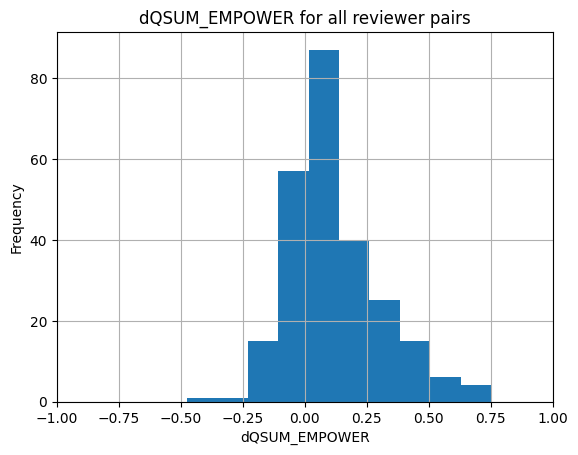

,dQSUM_EXPLICIT
count,251.000000
mean,0.088219
std,0.156743
min,-0.485714
25%,0.000000
50%,0.057143
75%,0.171429
max,0.542857


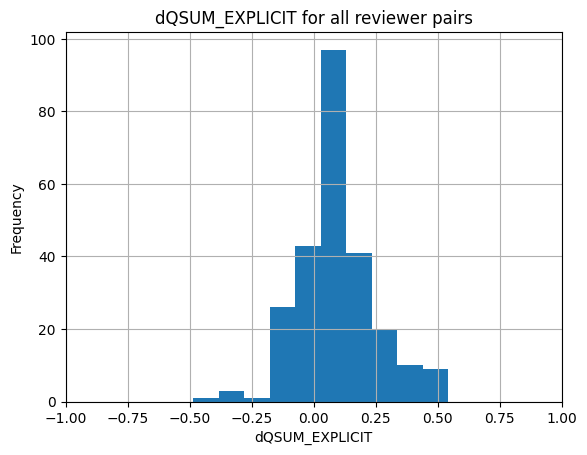

,dQSUM_EMPATHY
count,251.000000
mean,0.108367
std,0.198944
min,-0.566667
25%,0.000000
50%,0.066667
75%,0.233333
max,0.666667


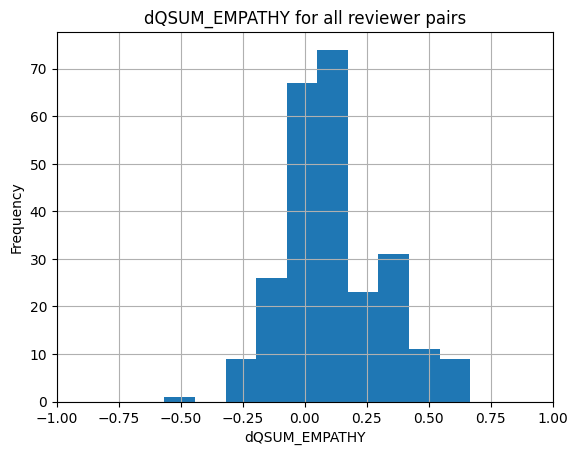

,dQSUM_ALL
count,251.000000
mean,0.105249
std,0.155602
min,-0.408696
25%,0.004348
50%,0.069565
75%,0.182609
max,0.539130


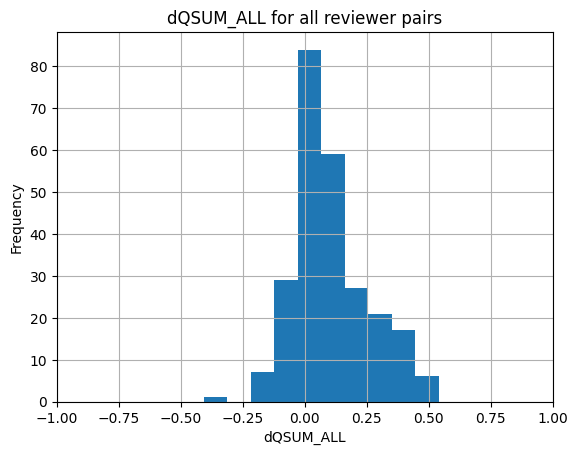

In [14]:
# SHOW BASIC STATS AND HISTOGRAM OF dQSUM

for dsum_group in dsum_groups:
  display(sum_df[dsum_group].describe())
  sum_df[dsum_group].hist()
  plt.xlabel(dsum_group)
  plt.ylabel('Frequency')
  plt.title(dsum_group + ' for all reviewer pairs')
  plt.xlim(-1,1)
  plt.show()

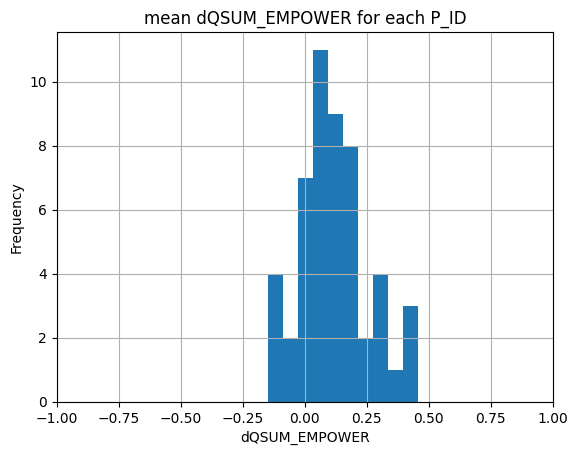

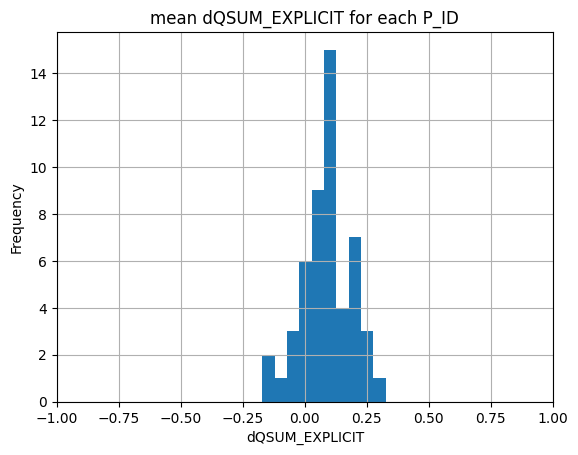

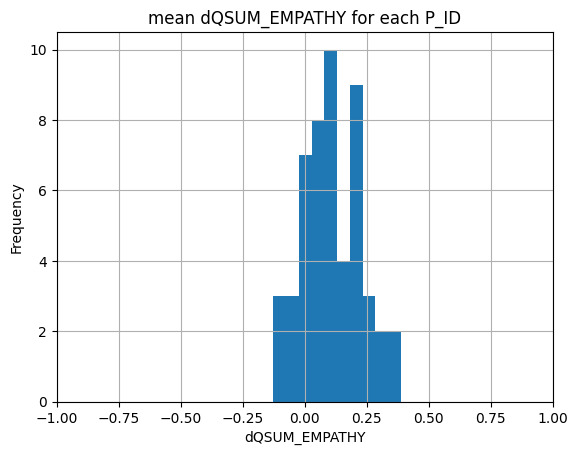

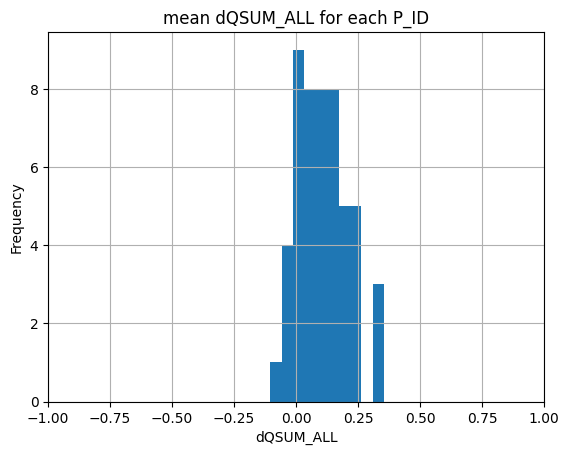

In [15]:
# HERE WE AVERAGE dQSUM FOR EACH PARTICIPANT
# In other words, each of the 5 reviewer dQSUMS for a participant's
# before and after videos are averaged.
gp_P_ID = sum_df.groupby('P_ID')
for dsum_group in dsum_groups:
  #display(g_VIDEO_NUM['QSUM'].mean())
  gp_P_ID[dsum_group].mean().hist()
  plt.xlabel(dsum_group)
  plt.ylabel('Frequency')
  plt.title('mean ' + dsum_group + ' for each P_ID')
  plt.xlim(-1,1)
  plt.show()

In [16]:
print('dQ - counts and means by group')
for group in ['REVIEWER_TYPE','P_BACKGROUND','ARM','REVIEWER_NAME']:
  g = sum_df.groupby(group)
  for dsum_group in dsum_groups:
    print('-----------------------')
    print('SUMGROUP: ' + sum_group)
    display(g[dsum_group].describe())


dQ - counts and means by group
-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.219608,0.218993,-0.100,0.025,0.175,0.425,0.750
TP,200.0,0.091250,0.177711,-0.475,-0.025,0.050,0.175,0.675


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.109804,0.166439,-0.485714,0.028571,0.114286,0.228571,0.400000
TP,200.0,0.082714,0.154126,-0.342857,0.000000,0.057143,0.142857,0.542857


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.192810,0.210852,-0.166667,0.000000,0.166667,0.300000,0.666667
TP,200.0,0.086833,0.190415,-0.566667,-0.033333,0.066667,0.166667,0.600000


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_TYPE,,,,,,,,
SP,51.0,0.177494,0.169850,-0.191304,0.026087,0.165217,0.317391,0.495652
TP,200.0,0.086826,0.146595,-0.408696,0.000000,0.060870,0.150000,0.539130


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.145000,0.169004,-0.025,0.07500,0.1000,0.15000,0.425
Nurse,94.0,0.118351,0.174411,-0.475,0.02500,0.0750,0.17500,0.650
PA,10.0,0.050000,0.091287,-0.075,-0.03125,0.0500,0.11250,0.200
PhD,18.0,0.109722,0.200209,-0.200,0.00000,0.0875,0.19375,0.625
Student,124.0,0.121976,0.213364,-0.275,-0.02500,0.0500,0.25000,0.750


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.160000,0.159847,-0.114286,0.171429,0.200000,0.257143,0.285714
Nurse,94.0,0.107295,0.152727,-0.342857,0.028571,0.071429,0.171429,0.542857
PA,10.0,0.094286,0.167169,-0.085714,-0.035714,0.071429,0.164286,0.485714
PhD,18.0,-0.030159,0.144851,-0.485714,-0.085714,-0.028571,0.050000,0.200000
Student,124.0,0.087558,0.154861,-0.285714,0.000000,0.071429,0.178571,0.542857


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.233333,0.179505,0.066667,0.066667,0.200000,0.366667,0.466667
Nurse,94.0,0.126241,0.195949,-0.566667,0.000000,0.100000,0.266667,0.566667
PA,10.0,0.003333,0.076093,-0.166667,0.000000,0.000000,0.058333,0.100000
PhD,18.0,0.068519,0.238314,-0.266667,-0.100000,0.000000,0.158333,0.600000
Student,124.0,0.104032,0.200162,-0.300000,-0.008333,0.066667,0.208333,0.666667


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
P_BACKGROUND,,,,,,,,
Doctor,5.0,0.172174,0.149656,0.000000,0.086957,0.173913,0.200000,0.400000
Nurse,94.0,0.116096,0.148075,-0.408696,0.026087,0.078261,0.195652,0.469565
PA,10.0,0.050435,0.062005,-0.043478,0.008696,0.056522,0.084783,0.147826
PhD,18.0,0.052174,0.170086,-0.191304,-0.063043,0.039130,0.128261,0.434783
Student,124.0,0.106452,0.163387,-0.182609,0.000000,0.060870,0.193478,0.539130


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.064516,0.157537,-0.275,0.000,0.025,0.1250,0.750
S,127.0,0.168898,0.211118,-0.475,0.025,0.125,0.3125,0.675


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.048157,0.133036,-0.485714,0.000000,0.028571,0.114286,0.457143
S,127.0,0.127334,0.168369,-0.285714,0.028571,0.114286,0.228571,0.542857


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.072849,0.165572,-0.266667,-0.008333,0.066667,0.133333,0.600000
S,127.0,0.143045,0.222068,-0.566667,0.000000,0.100000,0.300000,0.666667


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
ARM,,,,,,,,
C,124.0,0.061851,0.123301,-0.191304,0.000000,0.043478,0.115217,0.504348
S,127.0,0.147621,0.171860,-0.408696,0.013043,0.121739,0.282609,0.539130


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,3.312500e-01,0.124791,0.200,0.23750,3.375000e-01,0.43125,0.450
SP1,4.0,3.500000e-01,0.393171,0.000,0.01875,3.250000e-01,0.65625,0.750
SP10,4.0,1.125000e-01,0.208666,0.000,0.00000,1.250000e-02,0.12500,0.425
SP11,5.0,1.800000e-01,0.212426,-0.025,0.02500,1.250000e-01,0.27500,0.500
SP12,4.0,2.000000e-01,0.167083,0.100,0.11875,1.250000e-01,0.20625,0.450
SP2,8.0,1.031250e-01,0.119102,0.000,0.02500,5.000000e-02,0.13750,0.325
SP3,7.0,3.928571e-01,0.216369,0.050,0.27500,4.250000e-01,0.53750,0.650
SP4,2.0,-5.551115e-17,0.106066,-0.075,-0.03750,-5.551115e-17,0.03750,0.075
SP5,2.0,2.000000e-01,0.424264,-0.100,0.05000,2.000000e-01,0.35000,0.500


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.264286,0.162255,0.028571,0.242857,0.314286,0.335714,0.400000
SP1,4.0,-0.042857,0.315150,-0.485714,-0.121429,0.028571,0.107143,0.257143
SP10,4.0,0.057143,0.077372,0.000000,0.021429,0.028571,0.064286,0.171429
SP11,5.0,0.080000,0.046948,0.028571,0.028571,0.114286,0.114286,0.114286
SP12,4.0,0.050000,0.128571,-0.057143,-0.035714,0.014286,0.100000,0.228571
SP2,8.0,0.071429,0.116309,0.000000,0.000000,0.028571,0.071429,0.342857
SP3,7.0,0.228571,0.101686,0.085714,0.157143,0.257143,0.300000,0.342857
SP4,2.0,0.014286,0.222234,-0.142857,-0.064286,0.014286,0.092857,0.171429
SP5,2.0,0.057143,0.242437,-0.114286,-0.028571,0.057143,0.142857,0.228571


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,0.241667,0.250000,0.000000,0.075000,0.200000,0.366667,0.566667
SP1,4.0,0.191667,0.324751,-0.166667,0.008333,0.166667,0.350000,0.600000
SP10,4.0,0.350000,0.261760,0.000000,0.225000,0.416667,0.541667,0.566667
SP11,5.0,0.066667,0.113039,0.000000,0.000000,0.033333,0.033333,0.266667
SP12,4.0,0.233333,0.151535,0.100000,0.125000,0.200000,0.308333,0.433333
SP2,8.0,0.075000,0.140011,-0.033333,0.000000,0.000000,0.100000,0.300000
SP3,7.0,0.276190,0.122798,0.066667,0.233333,0.300000,0.333333,0.433333
SP4,2.0,-0.050000,0.023570,-0.066667,-0.058333,-0.050000,-0.041667,-0.033333
SP5,2.0,0.250000,0.070711,0.200000,0.225000,0.250000,0.275000,0.300000


-----------------------
SUMGROUP: QSUM_ALL


,count,mean,std,min,25%,50%,75%,max
REVIEWER_NAME,,,,,,,,
SP0,4.0,2.826087e-01,0.152360,0.078261,0.215217,3.130435e-01,0.380435,0.426087
SP1,4.0,1.760870e-01,0.311621,-0.191304,-0.028261,2.304348e-01,0.434783,0.434783
SP10,4.0,1.652174e-01,0.121324,0.008696,0.126087,1.739130e-01,0.213043,0.304348
SP11,5.0,1.182609e-01,0.130377,0.008696,0.026087,7.826087e-02,0.147826,0.330435
SP12,4.0,1.695652e-01,0.115470,0.060870,0.106522,1.434783e-01,0.206522,0.330435
SP2,8.0,8.260870e-02,0.116757,0.000000,0.015217,2.173913e-02,0.102174,0.286957
SP3,7.0,3.055901e-01,0.141593,0.060870,0.252174,3.217391e-01,0.391304,0.469565
SP4,2.0,5.551115e-17,0.098380,-0.069565,-0.034783,5.551115e-17,0.034783,0.069565
SP5,2.0,1.695652e-01,0.252099,-0.008696,0.080435,1.695652e-01,0.258696,0.347826


In [17]:
# TEMP - mistake
# paired t-test First vs Second for Control

from scipy.stats import ttest_rel  # Note this is different (paired)


sampleFirst = sum_df[sum_df['ARM'] == 'S'][sum_group]
sampleSecond = sum_df[sum_df['ARM'] == 'S'][sum_group]
sampleA = sum_df[sum_df['ARM'] == 'C'][sum_group]
sampleB = gb_P_ID_dQ_mean[gb_P_ID_dQ_mean['ARM'] == 'C'][dsum_group]


# One-sample
t_stat, p_value = ttest_ind(sampleS, sampleC, 0, False)
print(dsum_group + " : One-sample t-test on differences:", t_stat, p_value)


KeyError: 'QSUM_ALL'

## t-test on difference of mean dQSUM: Control vs. SOPHIE

In [ ]:
# USING ALL REVIEWS
from scipy.stats import ttest_ind

for dsum_group in dsum_groups:
  gb_P_ID_dQ_mean = sum_df.groupby('P_ID')[dsum_group].mean().reset_index()
  gb_P_ID_dQ_mean = gb_P_ID_dQ_mean.merge(pivoted_df[['P_ID', 'ARM']].drop_duplicates(),
                                                on='P_ID')
  #display(gp_P_ID_dQSUM_mean.head())
  #print(type(gp_P_ID_dQSUM_mean))
  sampleS = gb_P_ID_dQ_mean[gb_P_ID_dQ_mean['ARM'] == 'S'][dsum_group]
  sampleC = gb_P_ID_dQ_mean[gb_P_ID_dQ_mean['ARM'] == 'C'][dsum_group]


  # One-sample
  t_stat, p_value = ttest_ind(sampleS, sampleC, 0, False)
  print(dsum_group + " : One-sample t-test on differences:", t_stat, p_value)

In [ ]:
# USING ONLY TP REVIEWS
for dsum_group in dsum_groups:
  gb_P_ID_dQ_mean = sum_df[sum_df['REVIEWER_TYPE'] == 'TP'].groupby('P_ID')[dsum_group].mean().reset_index()
  gb_P_ID_dQ_mean = gb_P_ID_dQ_mean.merge(sum_df[['P_ID', 'ARM']].drop_duplicates(),
                                          on='P_ID')


  #display(gp_P_ID_dQSUM_mean.head())
  #print(type(gp_P_ID_dQSUM_mean))
  sampleS = gb_P_ID_dQ_mean[gb_P_ID_dQ_mean['ARM'] == 'S'][dsum_group]
  sampleC = gb_P_ID_dQ_mean[gb_P_ID_dQ_mean['ARM'] == 'C'][dsum_group]


  # One-sample
  t_stat, p_value = ttest_ind(sampleS, sampleC, 0, False)
  print(dsum_group + " : One-sample t-test on differences:", t_stat, p_value)

## Inter-Rater agreement for dQSUM

There are 4 TP (third party reviewers) who each rated the 102 videos.

Each of the 102 videos also has a rating made by the SP (standardized patient).

We first consider the inter-rater agreement between the four TP.

Since the dQSUM is a numerical score, Cohen's Kappa is not very appropriate. This is because Cohen's Kappa measures agreement between categorical data, and the QSUM scores are a sum of 19 questions (which have a 1-6 or a 1-10 rating) - i.e. making the data very "numerical" as opposed to "categorical".


#### Intra-class Correlation Coefficient (ICC)
The information provided represents the results of an Intra-class Correlation Coefficient (ICC) analysis, specifically different types of ICC calculated under various assumptions.

Each type corresponds to different assumptions about raters and measurements:

*    ICC1: Measures the reliability of single raters, assuming absolute agreement, with raters treated as random effects.
*    ICC2: Measures the reliability of single raters, assuming consistency across raters, with raters treated as random effects.
*    ICC3: Measures the reliability of single raters, assuming consistency, with raters treated as fixed effects.
*    ICC1k: Reliability of the mean of multiple raters (k raters) for absolute agreement.
*    ICC2k: Reliability of the mean of multiple raters (k raters) for consistency, assuming raters as random effects.
*    ICC3k: Reliability of the mean of multiple raters (k raters) for consistency, assuming raters as fixed effects.

Best ICC Type to Use:

*    ICC1: Use if you care about absolute agreement (e.g., ensuring all raters give the exact same scores).
*    ICC2: Use if you care about consistency across random raters (e.g., ensuring raters rank items similarly, but not necessarily identically).
*    ICC3: Use if raters are fixed (e.g., specific raters of interest, not randomly sampled).
*    For average measures, use ICC1k, ICC2k, or ICC3k based on your study design.

Interpretation of Agreement Levels:

*    $ICC<0.5$: Poor reliability.
*    $0.5≤ICC<0.75$: Moderate reliability.
*    $0.75≤ICC<0.9$: Good reliability.
*    $ICC≥0.9$: Excellent reliability.

In [18]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.4 MB/s eta 0:00:00


In [19]:
# THIS CELL IS JUST SAMPLE MADE UP DATA TO SHOW HOW THE ICC CODE WORKS.
import pandas as pd
import pingouin as pg

# Example data: Each row is an element, and each column is a rater's score
data = {
    'Rater1': [3.5, 4.0, 3.8, 4.2, 4.1],
    'Rater2': [3.6, 3.9, 3.7, 4.3, 4.2],
    'Rater3': [3.4, 4.1, 3.9, 4.4, 4.3],
    'Rater4': [3.5, 4.0, 3.8, 4.2, 4.1]
}
df2 = pd.DataFrame(data)

# Reshape data to long format for ICC calculation
df_long = df2.reset_index().melt(id_vars='index', var_name='Rater', value_name='Score')

# Rename 'index' to 'Element' for clarity
df_long = df_long.rename(columns={'index': 'Element'})
display(df_long)
# Compute ICC
icc = pg.intraclass_corr(data=df_long, targets='Element', raters='Rater', ratings='Score')

# Display ICC results
print(icc)

,Element,Rater,Score
0,0,Rater1,3.5
1,1,Rater1,4.0
2,2,Rater1,3.8
3,3,Rater1,4.2
4,4,Rater1,4.1
5,0,Rater2,3.6
6,1,Rater2,3.9
7,2,Rater2,3.7
8,3,Rater2,4.3
9,4,Rater2,4.2


    Type              Description       ICC          F  df1  df2  \
0   ICC1   Single raters absolute  0.924606  50.054348    4   15   
1   ICC2     Single random raters  0.924775  56.851852    4   12   
2   ICC3      Single fixed raters  0.933168  56.851852    4   12   
3  ICC1k  Average raters absolute  0.980022  50.054348    4   15   
4  ICC2k    Average random raters  0.980069  56.851852    4   12   
5  ICC3k     Average fixed raters  0.982410  56.851852    4   12   

           pval         CI95%  
0  1.682514e-08  [0.75, 0.99]  
1  1.062401e-07  [0.75, 0.99]  
2  1.062401e-07  [0.76, 0.99]  
3  1.682514e-08   [0.92, 1.0]  
4  1.062401e-07   [0.92, 1.0]  
5  1.062401e-07   [0.93, 1.0]  


In [20]:
df.head()

,VIDEO_NUM,P_ID,ARM,FIRST_SECOND,CASE_TITLE,P_BACKGROUND,SP_NAME,REVIEWER_NAME,REVIEWER_TYPE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,QSUM_EMPOWER,QSUM_EXPLICIT,QSUM_EMPATHY,QSUM_ALL
0,video1829885929,1,S,First,Pat Smith,Student,SP11,SP11,SP,1,1,1,1,1,2,9,4,5,5,5,3,9,4,4,1,5,8,4,0.400,0.885714,0.733333,0.634783
1,video8829885929,1,S,Second,Lois Bell,Student,SP11,SP11,SP,2,5,1,1,5,5,8,5,5,5,5,5,10,3,4,4,5,7,5,0.675,1.000000,0.766667,0.782609
2,video1757986894,0,C,First,Lois Bell,PA,SP0,SP0,SP,5,2,1,3,3,5,8,4,2,5,5,5,9,5,5,4,5,10,10,0.675,0.857143,0.966667,0.834783
3,video2757986894,0,C,Second,Pat Smith,PA,SP0,SP0,SP,5,2,5,3,5,5,10,5,1,5,5,5,10,5,5,4,5,10,10,0.875,0.885714,0.966667,0.913043
4,video1631554860,2,S,First,Jill Cooper,Student,SP4,SP4,SP,5,1,1,1,5,5,4,4,5,5,5,2,8,2,3,5,2,2,2,0.550,0.828571,0.466667,0.582609


We should use average, fixed raters score on QSUM.

In [21]:
# CALCULATE ICC FOR QSUM AMONG TP REVIEWERS ONLY
icc = pg.intraclass_corr(data=df[df['REVIEWER_TYPE'] == 'TP'], targets='P_ID', raters='REVIEWER_NAME', ratings='QSUM_ALL', nan_policy='omit')
print(icc)

    Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.481390  4.712922   50  153  7.412314e-14   
1   ICC2     Single random raters  0.509519  8.451234   50  150  1.090823e-24   
2   ICC3      Single fixed raters  0.650693  8.451234   50  150  1.090823e-24   
3  ICC1k  Average raters absolute  0.787817  4.712922   50  153  7.412314e-14   
4  ICC2k    Average random raters  0.806023  8.451234   50  150  1.090823e-24   
5  ICC3k     Average fixed raters  0.881674  8.451234   50  150  1.090823e-24   

          CI95%  
0  [0.34, 0.62]  
1  [0.27, 0.69]  
2  [0.53, 0.76]  
3  [0.67, 0.87]  
4   [0.59, 0.9]  
5  [0.82, 0.93]  


Here we look at reliability of dQSUM. However, this seems unnecessary as ICC automatically creates metrics for absolute vs. non-absolute, so it seems we should not use dQSUM.

In [22]:
# CALCULATE ICC FOR dQSUM AMONG TP REVIEWERS ONLY
icc = pg.intraclass_corr(data=pivoted_df[pivoted_df['REVIEWER_TYPE'] == 'TP'], targets='P_ID', raters='REVIEWER_NAME', ratings='dQSUM_ALL', nan_policy='omit')
print(icc)

    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.229976  2.194642   47  144  0.000205   
1   ICC2     Single random raters  0.250229  2.552850   47  141  0.000012   
2   ICC3      Single fixed raters  0.279649  2.552850   47  141  0.000012   
3  ICC1k  Average raters absolute  0.544345  2.194642   47  144  0.000205   
4  ICC2k    Average random raters  0.571727  2.552850   47  141  0.000012   
5  ICC3k     Average fixed raters  0.608281  2.552850   47  141  0.000012   

          CI95%  
0   [0.09, 0.4]  
1  [0.12, 0.41]  
2  [0.14, 0.44]  
3  [0.29, 0.72]  
4  [0.34, 0.74]  
5  [0.39, 0.76]  
